In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
from tqdm import tqdm
from sklearn.metrics import f1_score
import os 
import lightgbm as lgb
import gc

# Prep stage 

In [2]:
model_name = 'model_18'
MainPth = 'C:/Users/denis/Machine_Learning_Competitions/indian_hack/'
ModelFolder = MainPth + model_name + '/'

In [3]:
def check_empy(pth):
    if ( os.path.exists(pth) ):
        if (len(os.listdir(pth)) > 0):
            raise Exception('Folder is not empy!')
        else:
            pass

In [4]:
train_pth = ModelFolder + '/train/'
test_pth = ModelFolder + '/test/'

scores = []

# check if files in folder - no re-writing is good 
check_empy(train_pth)
check_empy(test_pth)

# create folder if it does not exist 
if not os.path.exists(train_pth):
    os.makedirs(train_pth)
    
if not os.path.exists(test_pth):
    os.makedirs(test_pth)

Exception: Folder is not empy!

# Read data 

In [13]:
data_pth = MainPth + 'data/'

In [14]:
train = pd.read_csv(data_pth + 'train.csv')
train = train.sort_values(by='DateTime').reset_index(drop=True)

test = pd.read_csv(data_pth + 'test.csv')
ssub = pd.read_csv(data_pth + 'sample_submission.csv')
history = pd.read_csv(data_pth + 'historical_user_logs.csv')

train['session_id'] = np.arange(len(train))
test['session_id'] = np.arange(len(test)) + len(train)

In [7]:
np.min(train['DateTime']), np.min(test['DateTime']), np.min(history['DateTime'])

('2017-07-02 00:00', '2017-07-08 00:00', '2017-05-28 15:44')

In [8]:
np.max(train['DateTime']), np.max(test['DateTime']), np.max(history['DateTime'])

('2017-07-07 23:59', '2017-07-09 21:29', '2017-07-01 23:59')

In [9]:
train.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,0,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,1,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,2,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,3,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,4,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


# history

In [10]:
history['action'] = (history['action']=='interest')*1
history['DateTime'] = pd.to_datetime(history['DateTime'])

In [11]:
print(history.shape)
history = history.drop_duplicates(subset=['DateTime','user_id'])
print(history.shape)

(24287534, 4)
(10692974, 4)


In [12]:
%%time
def diff(x):
    d = np.diff(x)
    return list(d)

t = history[['user_id','DateTime']].groupby('user_id').agg(diff).reset_index()

Wall time: 10 s


In [13]:
t = history[['user_id','DateTime']].groupby('user_id').agg(diff).reset_index()

ids = []
diffs = []
time_sessions_id = []
for i in tqdm(range(len(t))):
    time_array = t['DateTime'][i]
    a = [-1] + [x.item() / 1e9 / 60 for x in time_array]
    diffs += a
    ids += [t['user_id'][i]] * len(a)
    
    sessions = [0]
    if len(a)!=1:
        s = 0
        for j in range(1, len(a)):
            if a[j] > 30: # 30 min diff between pages 
                s += 1
            sessions.append(s)
    time_sessions_id += sessions

100%|████████████████████████████████████████████████████████████████████████| 171309/171309 [00:23<00:00, 7435.08it/s]


In [14]:
history = history.sort_values(by=['user_id','DateTime']).reset_index(drop=True)
history['h_time_since_last_add'] = diffs
history['h_time_sessions_id'] = time_sessions_id

In [15]:
history['day_DateTime'] = history['DateTime'].dt.day

In [16]:
temp = history[['user_id','h_time_sessions_id']].groupby('user_id').agg('max').reset_index()
temp = temp.rename({'h_time_sessions_id':'max_hist_ses'}, axis=1)
train = pd.merge(train, temp, how='left', on='user_id')
test = pd.merge(test, temp, how='left', on='user_id')

In [17]:
def ret_set(x):
    return len(set(x))

temp = history[['user_id','day_DateTime']].groupby('user_id').agg(ret_set).reset_index()
temp = temp.rename({'day_DateTime':'hist_num_active_days'}, axis=1)
train = pd.merge(train, temp, how='left', on='user_id')
test = pd.merge(test, temp, how='left', on='user_id')

In [18]:
train['max_hist_ses'] = train['max_hist_ses'].fillna(0)
test['max_hist_ses'] = test['max_hist_ses'].fillna(0)
train['hist_num_active_days'] = train['hist_num_active_days'].fillna(-1)
test['hist_num_active_days'] = test['hist_num_active_days'].fillna(-1)

train['ses_per_day_hist'] = train['max_hist_ses'] / train['hist_num_active_days']
test['ses_per_day_hist'] = test['max_hist_ses'] / test['hist_num_active_days']

In [19]:
train.shape, test.shape

((463291, 18), (128858, 17))

In [20]:
train.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,max_hist_ses,hist_num_active_days,ses_per_day_hist
0,0,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0,13.0,9.0,1.444444
1,1,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,9.0,6.0,1.500000
2,2,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0,9.0,6.0,1.500000
3,3,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0,11.0,8.0,1.375000
4,4,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0,6.0,4.0,1.500000


# hist 

In [21]:
history = pd.read_csv(data_pth + 'historical_user_logs.csv')
history['action'] = (history['action']=='interest')*1
history['DateTime'] = pd.to_datetime(history['DateTime'])

In [22]:
t = history[['user_id','action']].groupby('user_id').agg('mean').reset_index()
t = t.rename({'action':'action_mean'},axis=1)
train = pd.merge(train, t, how='left', on='user_id')
test = pd.merge(test, t, how='left', on='user_id')
train['action_mean'] = train['action_mean'].fillna(-1)
test['action_mean'] = test['action_mean'].fillna(-1)

t = history[['user_id','action']].groupby('user_id').agg('count').reset_index()
t = t.rename({'action':'action_count'},axis=1)
train = pd.merge(train, t, how='left', on='user_id')
test = pd.merge(test, t, how='left', on='user_id')
train['action_count'] = train['action_count'].fillna(0)
test['action_count'] = test['action_count'].fillna(0)

t = history[['user_id','action','product']].groupby(['user_id','product']).agg('mean').reset_index()
t = t.rename({'action':'actionlproduct_mean'},axis=1)
train = pd.merge(train, t, how='left', on=['user_id','product'])
test = pd.merge(test, t, how='left', on=['user_id','product'])
train['actionlproduct_mean'] = train['actionlproduct_mean'].fillna(-1)
test['actionlproduct_mean'] = test['actionlproduct_mean'].fillna(-1)

t = history[['user_id','action','product']].groupby(['user_id','product']).agg('count').reset_index()
t = t.rename({'action':'actionlproduct_count'},axis=1)
train = pd.merge(train, t, how='left', on=['user_id','product'])
test = pd.merge(test, t, how='left', on=['user_id','product'])
train['actionlproduct_count'] = train['actionlproduct_count'].fillna(0)
test['actionlproduct_count'] = test['actionlproduct_count'].fillna(0)

In [23]:
train.shape, test.shape

((463291, 22), (128858, 21))

In [24]:
# t_piv = t.pivot(columns='product',values='actionlproduct_mean',index='user_id').reset_index()

In [25]:
train.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,...,city_development_index,var_1,is_click,max_hist_ses,hist_num_active_days,ses_per_day_hist,action_mean,action_count,actionlproduct_mean,actionlproduct_count
0,0,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,...,3.0,0,0,13.0,9.0,1.444444,0.000000,627.0,0.000000,5.0
1,1,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,...,NaN,0,0,9.0,6.0,1.500000,0.000000,62.0,0.000000,11.0
2,2,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,...,NaN,0,0,9.0,6.0,1.500000,0.000000,62.0,0.000000,11.0
3,3,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,...,2.0,1,0,11.0,8.0,1.375000,0.046512,43.0,0.111111,9.0
4,4,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,...,2.0,1,0,6.0,4.0,1.500000,0.050000,60.0,0.000000,3.0


# Time since last add 

In [26]:
train.shape, test.shape

((463291, 22), (128858, 21))

In [27]:
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])

# left -> right

In [28]:
def diff(x):
    d = np.diff(x)
    return list(d)

In [29]:
all_data = pd.concat([train.drop('is_click',axis=1),test],axis=0).reset_index(drop=True)
all_data = all_data.sort_values(by='DateTime').reset_index(drop=True)
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])
all_data = all_data[['user_id','DateTime']].drop_duplicates().reset_index(drop=True)
all_data = all_data.sort_values(by=['user_id','DateTime']).reset_index(drop=True)
all_data.shape

(479746, 2)

In [30]:
t = all_data[['user_id','DateTime']].groupby('user_id').agg(diff).reset_index()

ids = []
diffs = []
time_sessions_id = []
for i in tqdm(range(len(t))):
    time_array = t['DateTime'][i]
    a = [-1] + [x.item() / 1e9 / 60 for x in time_array]
    diffs += a
    ids += [t['user_id'][i]] * len(a)
    
    sessions = [0]
    if len(a)!=1:
        s = 0
        for j in range(1, len(a)):
            if a[j] > 30: # 30 min diff between pages 
                s += 1
            sessions.append(s)
    time_sessions_id += sessions
    
print(len(ids), len(diffs), len(time_sessions_id))

all_data = all_data.sort_values(by=['user_id','DateTime']).reset_index(drop=True)
all_data['time_since_last_add'] = diffs
all_data['time_sessions_id'] = time_sessions_id

100%|███████████████████████████████████████████████████████████████████████| 177729/177729 [00:06<00:00, 26609.00it/s]


479746 479746 479746


In [31]:
# get number of page to the end of current session
def n_page(x):
    t = np.arange(len(x))
    return [len(x) - t - 1 for t in t]

t = all_data[['user_id','time_sessions_id','DateTime']].groupby(['user_id','time_sessions_id']).agg(n_page).reset_index()

ids = []
time_sessions_id = []
n_page = []

for i in tqdm(range(len(t))):
    time_array = t['DateTime'][i]
    a = list(time_array)
    ids += [t['user_id'][i]] * len(a)
    time_sessions_id += [t['time_sessions_id'][i]] * len(a)
    n_page += a
    
print(len(ids), len(time_sessions_id), len(n_page))

all_data = all_data.sort_values(by=['user_id','time_sessions_id']).reset_index(drop=True)
all_data['n_page_in_session'] = n_page

100%|███████████████████████████████████████████████████████████████████████| 405021/405021 [00:17<00:00, 22816.81it/s]


479746 479746 479746


In [32]:
all_data.head()

,user_id,DateTime,time_since_last_add,time_sessions_id,n_page_in_session
0,4,2017-07-02 14:51:00,-1.0,0,0
1,4,2017-07-09 11:07:00,9856.0,1,0
2,6,2017-07-06 12:33:00,-1.0,0,0
3,19,2017-07-02 15:25:00,-1.0,0,0
4,19,2017-07-05 09:22:00,3957.0,1,0


In [33]:
# number of sessions 
t = all_data[['user_id','time_sessions_id']].groupby('user_id').agg('max').reset_index()
t = t.rename({'time_sessions_id':'max_number_sessions'},axis=1)
all_data = pd.merge(all_data, t, how='left', on='user_id')

# number of pages in session
t = all_data[['user_id','time_sessions_id','time_since_last_add']].groupby(['user_id','time_sessions_id']).agg('count').reset_index()
t = t.rename({'time_since_last_add':'num_pages_this_session'},axis=1)
all_data = pd.merge(all_data, t, how='left', on=['user_id','time_sessions_id'])

# mean of time per session
t = all_data[['user_id','time_sessions_id','time_since_last_add']].groupby(['user_id','time_sessions_id']).agg('mean').reset_index()
t = t.rename({'time_since_last_add':'mean_time_ses'},axis=1)
all_data = pd.merge(all_data, t, how='left', on=['user_id','time_sessions_id'])

# std of time per session
t = all_data[['user_id','time_sessions_id','time_since_last_add']].groupby(['user_id','time_sessions_id']).agg('std').reset_index()
t = t.rename({'time_since_last_add':'std_time_ses'},axis=1)
all_data = pd.merge(all_data, t, how='left', on=['user_id','time_sessions_id'])

In [34]:
all_data['DateTime'] = all_data['DateTime'].astype('str')
train['DateTime'] = train['DateTime'].astype('str')
test['DateTime'] = test['DateTime'].astype('str')

In [35]:
train = pd.merge(train, all_data, how='left', on=['user_id','DateTime'])
test = pd.merge(test, all_data, how='left', on=['user_id','DateTime'])

### number of ads per ses

In [36]:
t = train[['user_id','time_sessions_id','time_since_last_add']].groupby(['user_id','time_sessions_id']).agg('count').reset_index()
t = t.rename({'time_since_last_add':'num_ads_ses'},axis=1)
train = pd.merge(train, t, how='left', on=['user_id','time_sessions_id'])

t = test[['user_id','time_sessions_id','time_since_last_add']].groupby(['user_id','time_sessions_id']).agg('count').reset_index()
t = t.rename({'time_since_last_add':'num_ads_ses'},axis=1)
test = pd.merge(test, t, how='left', on=['user_id','time_sessions_id'])

### stats on session length 

In [37]:
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])
t = all_data[['user_id', 'time_sessions_id','DateTime']].groupby(['user_id','time_sessions_id']).agg(lambda x: np.max(x)-np.min(x))
t = t.reset_index()
t['DateTime'] = t['DateTime'].dt.seconds

for a in tqdm(['mean', 'max', 'min', 'std', 'sum']):
    temp = t[['user_id','DateTime']].groupby(['user_id']).agg(a).reset_index()
    temp = temp.rename({'DateTime':'ses_time_'+a},axis=1)
    train = pd.merge(train, temp, how='left', on='user_id')
    test = pd.merge(test, temp, how='left', on='user_id')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.72it/s]


In [38]:
# drop session info 
train = train.drop('time_sessions_id',axis=1)
test = test.drop('time_sessions_id',axis=1)

In [39]:
train['std_time_ses'] = train['std_time_ses'].fillna(0)
test['std_time_ses'] = test['std_time_ses'].fillna(0)

# right -> left 

In [40]:
def diff(x):
    x = x[::-1]
    d = np.diff(x)
    return list(d)

In [41]:
all_data = pd.concat([train.drop('is_click',axis=1),test],axis=0).reset_index(drop=True)
all_data = all_data.sort_values(by='DateTime').reset_index(drop=True)
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])
all_data = all_data[['user_id','DateTime']].drop_duplicates().reset_index(drop=True)
all_data = all_data.sort_values(by=['user_id','DateTime']).reset_index(drop=True)
all_data.shape

(479746, 2)

In [42]:
t = all_data[['user_id','DateTime']].groupby('user_id').agg(diff).reset_index()

ids = []
diffs = []
time_sessions_id = []
for i in tqdm(range(len(t))):
    time_array = t['DateTime'][i]
    a = [-1] + [x.item() / 1e9 / 60 for x in time_array]
    diffs += a
    ids += [t['user_id'][i]] * len(a)
    
    sessions = [0]
    if len(a)!=1:
        s = 0
        for j in range(1, len(a)):
            if a[j] > 30: # 30 min diff between pages 
                s += 1
            sessions.append(s)
    time_sessions_id += sessions

100%|███████████████████████████████████████████████████████████████████████| 177729/177729 [00:06<00:00, 28010.93it/s]


In [43]:
all_data = all_data.sort_values(by=['user_id','DateTime'], ascending=[True, False]).reset_index(drop=True)
all_data['reversed_time_since_last_add'] = diffs

all_data['DateTime'] = all_data['DateTime'].astype('str')
train['DateTime'] = train['DateTime'].astype('str')
test['DateTime'] = test['DateTime'].astype('str')

train = pd.merge(train, all_data, how='left', on=['user_id','DateTime'])
test = pd.merge(test, all_data, how='left', on=['user_id','DateTime'])

In [44]:
all_data.head(10)

,user_id,DateTime,reversed_time_since_last_add
0,4,2017-07-09 11:07:00,-1.0
1,4,2017-07-02 14:51:00,-9856.0
2,6,2017-07-06 12:33:00,-1.0
3,19,2017-07-09 15:22:00,-1.0
4,19,2017-07-05 09:22:00,-6120.0
5,19,2017-07-02 15:25:00,-3957.0
6,25,2017-07-03 20:14:00,-1.0
7,26,2017-07-06 20:00:00,-1.0
8,30,2017-07-02 10:18:00,-1.0
9,33,2017-07-07 10:14:00,-1.0


In [45]:
train.shape, test.shape

((463291, 35), (128858, 34))

In [46]:
train.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,...,num_pages_this_session,mean_time_ses,std_time_ses,num_ads_ses,ses_time_mean,ses_time_max,ses_time_min,ses_time_std,ses_time_sum,reversed_time_since_last_add
0,0,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,...,1,-1.0,0.00000,1,0.0,0,0,0.000000,0,-7089.0
1,1,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,...,2,0.5,2.12132,3,300.0,480,120,254.558441,600,-2.0
2,2,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,...,2,0.5,2.12132,3,300.0,480,120,254.558441,600,-2.0
3,3,2017-07-02 00:00:00,1097446,I,359520,13787,3,NaN,3.0,Male,...,1,-1.0,0.00000,1,60.0,480,0,149.398795,660,-2589.0
4,4,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,...,1,-1.0,0.00000,1,60.0,180,0,103.923048,180,-6675.0


# number of ads on same page 

In [47]:
temp = train[['DateTime','user_id','session_id']].groupby(['DateTime','user_id']).agg('count').reset_index()
temp = temp.rename({'session_id':'number_ads_page'},axis=1)
train = pd.merge(train, temp, how='left', on=['DateTime','user_id'])

temp = test[['DateTime','user_id','session_id']].groupby(['DateTime','user_id']).agg('count').reset_index()
temp = temp.rename({'session_id':'number_ads_page'},axis=1)
test = pd.merge(test, temp, how='left', on=['DateTime','user_id'])

In [48]:
history.head()

,DateTime,user_id,product,action
0,2017-05-28 15:44:00,704,B,0
1,2017-05-29 07:08:00,499679,F,0
2,2017-05-29 07:10:00,499679,G,0
3,2017-05-29 07:10:00,499679,G,0
4,2017-05-29 07:10:00,499679,G,0


# Datetime features 

In [49]:
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])

In [50]:
train['dt_hour'] = train['DateTime'].dt.hour
#train['dt_weekday'] = train['DateTime'].dt.dayofweek
train['dt_minsince2400'] = train['DateTime'].dt.hour * 60 + train['DateTime'].dt.minute

test['dt_hour'] = test['DateTime'].dt.hour
#test['dt_weekday'] = test['DateTime'].dt.dayofweek
test['dt_minsince2400'] = test['DateTime'].dt.hour * 60 + test['DateTime'].dt.minute

In [51]:
# train = train.sort_values(by='DateTime').reset_index(drop=True)

# additional cat cols 

In [52]:
cat_cols = ['user_id','product','campaign_id','webpage_id','product_category_1','product_category_2',
           'user_group_id', 'gender', 'age_level', 'user_depth', 'city_development_index', 'var_1']

In [53]:
user_cat = ['user_id','user_group_id', 'gender', 'age_level', 'user_depth', 'city_development_index', 'var_1']
add_cat = ['product','campaign_id','webpage_id','product_category_1','product_category_2']


print('len cat cols:', len(cat_cols))
for c1 in user_cat:
    train[c1] = train[c1].astype('str')
    test[c1] = test[c1].astype('str')
    for c2 in add_cat:
        train[c2] = train[c2].astype('str')
        test[c2] = test[c2].astype('str')
        
        train[c1+'_and_'+c2] = train[c1].astype('str') + '_and_' + train[c2].astype('str')
        test[c1+'_and_'+c2] = test[c1].astype('str') + '_and_' + test[c2].astype('str')
        cat_cols.append(c1+'_and_'+c2)
print('len cat cols:', len(cat_cols))

len cat cols: 12
len cat cols: 47


In [54]:
print('len cat cols:', len(cat_cols))
for i1 in range(len(add_cat)-1):
    for i2 in range(i1+1, len(add_cat)):
        c1 = add_cat[i1]
        c2 = add_cat[i2]
        
        train[c1+'_and_'+c2] = train[c1].astype('str') + '_and_' + train[c2].astype('str')
        test[c1+'_and_'+c2] = test[c1].astype('str') + '_and_' + test[c2].astype('str')
        cat_cols.append(c1+'_and_'+c2)
print('len cat cols:', len(cat_cols))

len cat cols: 47
len cat cols: 57


# Counters of user's demograpics 

def rel_len_set(x):
    return len(set(list(x)))

c = 'user_group_id'
t = all_data[['user_id','product']].groupby('product').agg(['count',rel_len_set]).reset_index()

# Prep X_train, X_test

In [55]:
X_train = train.drop(['DateTime','session_id'], axis=1)
X_test = test.drop(['DateTime','session_id'], axis=1)
y_train = train['is_click']

In [56]:
for cc in tqdm(cat_cols):
    
    fillna_const = 'MISSING_VALUE'
    
    X_train[cc] = X_train[cc].astype('str').fillna(fillna_const)
    X_test[cc] = X_test[cc].astype('str').fillna(fillna_const)
    
    X_train[cc] = X_train[cc].astype('category')
    X_test[cc] = X_test[cc].astype('category')

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:26<00:00,  2.17it/s]


# TFIDF

In [57]:
from scipy.sparse import csr_matrix

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(tokenizer=lambda x: x.split(' '))

In [59]:
tf_cols = ['product','campaign_id','webpage_id','product_category_1','product_category_2']

X = pd.concat([X_train[['user_id']+tf_cols], X_test[['user_id']+tf_cols]], axis=0).reset_index(drop=True)
print('X formed', X.shape)

for cc in tf_cols:
    temp = X[['user_id', cc]].groupby(['user_id']).agg(lambda x: ' '.join(x)).reset_index()
    X_trfd = tf.fit_transform(temp[cc])
    X_trfd = pd.DataFrame(X_trfd.todense(), columns = ['tfidf_'+cc+'_'+str(x) for x in tf.vocabulary_.values()])
    temp = temp.drop(cc,axis=1)
    temp = pd.concat([temp, X_trfd], axis=1)
    
    print(cc, X_trfd.shape)

    X_train = pd.merge(X_train, temp, how='left', on='user_id')
    X_test = pd.merge(X_test, temp, how='left', on='user_id')

X formed (592149, 6)
product (177729, 10)
campaign_id (177729, 10)
webpage_id (177729, 9)
product_category_1 (177729, 5)
product_category_2 (177729, 32)


In [60]:
X_train.shape, X_test.shape

((463291, 147), (128858, 146))

In [61]:
X_train.head()

,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,...,tfidf_product_category_2_30,tfidf_product_category_2_17,tfidf_product_category_2_28,tfidf_product_category_2_14,tfidf_product_category_2_10,tfidf_product_category_2_15,tfidf_product_category_2_12,tfidf_product_category_2_1,tfidf_product_category_2_13,tfidf_product_category_2_29
0,858557,C,359520,13787,4,nan,10.0,Female,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000
1,243253,C,105960,11085,5,nan,8.0,Female,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000
2,243253,C,359520,13787,4,nan,8.0,Female,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000
3,1097446,I,359520,13787,3,nan,3.0,Male,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000
4,663656,C,405490,60305,3,nan,2.0,Male,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.969874,0.0,0.243608


# Lgb

In [62]:
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
def scoring(y_true, y_hat):
    return roc_auc_score(y_true, y_hat)

loss_function_name = 'auc'

kf = KFold(n_splits=10)
kf_lr = StratifiedKFold(n_splits=5, shuffle=True, random_state=424242)

In [63]:
def check_empy(pth):
    if ( os.path.exists(pth) ):
        if (len(os.listdir(pth)) > 0):
            raise Exception('Folder is not empy!')
        else:
            pass

In [64]:
params = {
    'objective':'binary', 
    'metric': 'AUC',
    'learning_rate': 0.01, 
    'random_state': 4242442,
    'verbose_eval': 0,
    'class_weight': 'balanced'
}
            
params['num_leaves'] = 145
params['min_data_in_leaf'] = 15
params['feature_fraction'] = 0.2244
params['bagging_fraction'] = 0.8713
params['subsample'] = 0.465
params['colsample_bytree'] = 0.0856
params['min_child_weight'] = 13
params['min_child_samples'] = 22
params['reg_lambda'] = 1
params['reg_alpha'] = 55
params['subsample_freq'] = 3

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict

In [66]:
train_pth = ModelFolder + 'train/'
test_pth = ModelFolder + 'test/'

scores = []

# write basic info
log_file_name = ModelFolder + '_log_file.txt'
with open(log_file_name, 'a') as the_file:
    the_file.write('Train, test shapes\n')
    the_file.write(str(X_train.shape)+'\n')
    the_file.write(str(X_test.shape)+'\n')

for n_fold, (train_index, test_index) in tqdm(enumerate(kf.split(X_train, y_train))):
    
    # replace cat cols 
    X_train_temp = X_train.iloc[train_index].reset_index(drop=True).copy()
    X_val_temp = X_train.iloc[test_index].reset_index(drop=True).copy()
    X_test_temp = X_test.reset_index(drop=True).copy()
    
    y_train_temp = X_train_temp['is_click']
    X_train_temp = X_train_temp.drop('is_click', axis=1)
    y_val_temp = X_val_temp['is_click']
    X_val_temp = X_val_temp.drop('is_click', axis=1)
    
    for cc in tqdm(cat_cols):
        le = LabelEncoder()
        le.fit(list(set(X_test[cc]) | set(X_train[cc])))
        print(le.classes_)
        X_train_temp[[cc]] = le.transform(X_train_temp[[cc]])
        X_val_temp[[cc]] = le.transform(X_val_temp[[cc]])
        X_test_temp[[cc]] = le.transform(X_test_temp[[cc]])
    
        lr = LinearRegression(n_jobs=-1)
        ohe = OneHotEncoder(sparse=True)
        ohe.fit(np.arange(len(le.classes_)).reshape(-1, 1))
        x_ohe_train = ohe.transform(X_train_temp[[cc]])
        x_ohe_val = ohe.transform(X_val_temp[[cc]])
        x_ohe_test = ohe.transform(X_test_temp[[cc]])
        
        lr.fit(x_ohe_train, y_train_temp)
    
        X_train_temp[cc] = cross_val_predict(lr, x_ohe_train, y_train_temp, cv=kf_lr, n_jobs=-1)
        X_val_temp[cc] = lr.predict(x_ohe_val)
        X_test_temp[cc] = lr.predict(x_ohe_test)
    
    print(X_train_temp.shape)
    
    lgb_data_train = lgb.Dataset(X_train_temp, 
                                 label=y_train_temp,
                                 free_raw_data=False)

    lgb_data_valid = lgb.Dataset(X_val_temp, 
                                 label=y_val_temp,
                                 free_raw_data=False,
                                 reference=lgb_data_train)
    model = lgb.train(params, 
                      lgb_data_train, 
                      valid_sets = lgb_data_valid,
                      verbose_eval=200,
                      #feval = lgb_f1_score,
                      early_stopping_rounds=200,
                      num_boost_round=500000)
    
    y_hat_valid = model.predict(X_val_temp)
    y_hat_test = model.predict(X_test_temp)
    
    y_hat_valid = pd.DataFrame({'DF_index':test_index, 'pred':y_hat_valid})
    y_hat_test = pd.DataFrame(y_hat_test)
    
    
    # save predictions 
    y_hat_valid.to_csv(train_pth+'nfold'+str(n_fold)+'.csv',index=False)
    y_hat_test.to_csv(test_pth+'nfold'+str(n_fold)+'.csv',index=False)
    
    # calculate score 
    score_valid = scoring(y_train[test_index].values, y_hat_valid['pred'])
    
    with open(log_file_name, 'a') as the_file:
        the_file.write('Score for '+ str(n_fold)+ ' fold: '+ str(score_valid) + '\n')
        
    scores.append(score_valid)
    
with open(log_file_name, 'a') as the_file:
    the_file.write('---\n')
    the_file.write('Mean score ' + str(np.mean(scores)) + '+' + str(np.std(scores)))

0it [00:00, ?it/s]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:10<09:22, 10.05s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:15<07:03,  7.70s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:21<06:24,  7.12s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:27<05:57,  6.75s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:32<05:38,  6.52s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:39<05:38,  6.63s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:45<05:26,  6.54s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:51<05:14,  6.42s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:56<05:02,  6.30s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:02<04:53,  6.24s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:07<04:42,  6.14s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:13<04:34,  6.10s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:25<04:51,  6.61s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:38<05:02,  7.03s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:50<05:09,  7.37s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [02:01<05:12,  7.62s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:12<05:12,  7.82s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:22<05:09,  7.93s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:32<05:04,  8.01s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:41<04:58,  8.06s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:49<04:50,  8.06s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [03:02<04:50,  8.30s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:09<04:39,  8.23s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:15<04:29,  8.16s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:22<04:19,  8.12s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:29<04:09,  8.06s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:37<04:02,  8.07s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:47<03:55,  8.11s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:56<03:47,  8.14s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [04:04<03:40,  8.15s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [04:11<03:31,  8.12s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:22<03:25,  8.21s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:30<03:16,  8.18s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:36<03:07,  8.14s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:43<02:58,  8.10s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:49<02:49,  8.05s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [05:00<02:42,  8.12s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [05:09<02:34,  8.15s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [05:18<02:27,  8.18s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [05:27<02:19,  8.19s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:36<02:11,  8.21s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:49<02:04,  8.33s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:58<01:56,  8.34s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [06:07<01:48,  8.36s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [06:17<01:40,  8.38s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [06:25<01:32,  8.39s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [06:36<01:24,  8.44s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [06:48<01:16,  8.51s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [06:59<01:08,  8.56s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [07:08<00:59,  8.57s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [07:19<00:51,  8.62s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [07:27<00:43,  8.61s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [07:34<00:34,  8.58s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [07:43<00:25,  8.59s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [07:51<00:17,  8.57s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [07:59<00:08,  8.57s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [08:08<00:00,  8.56s/it]


(416961, 146)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.630086
[400]	valid_0's auc: 0.639963
[600]	valid_0's auc: 0.646854
[800]	valid_0's auc: 0.651735
[1000]	valid_0's auc: 0.654654
[1200]	valid_0's auc: 0.656592
[1400]	valid_0's auc: 0.657897
[1600]	valid_0's auc: 0.658985
[1800]	valid_0's auc: 0.660013
[2000]	valid_0's auc: 0.660589
[2200]	valid_0's auc: 0.661182
[2400]	valid_0's auc: 0.661616
[2600]	valid_0's auc: 0.661985
[2800]	valid_0's auc: 0.662328
[3000]	valid_0's auc: 0.66252
[3200]	valid_0's auc: 0.662802
[3400]	valid_0's auc: 0.662913
[3600]	valid_0's auc: 0.663066
[3800]	valid_0's auc: 0.663247
[4000]	valid_0's auc: 0.663383
[4200]	valid_0's auc: 0.663501
[4400]	valid_0's auc: 0.66361
[4600]	valid_0's auc: 0.663675
[4800]	valid_0's auc: 0.663824
[5000]	valid_0's auc: 0.663901
[5200]	valid_0's auc: 0.664026
[5400]	valid_0's auc: 0.664095
[5600]	valid_0's auc: 0.664216
[5800]	valid_0's auc: 0.664355
Early stopping, best iteration

1it [24:19, 1459.08s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:10<09:25, 10.09s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:15<07:13,  7.89s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:21<06:22,  7.08s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:26<05:56,  6.73s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:32<05:37,  6.49s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:38<05:27,  6.42s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:43<05:13,  6.28s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:49<05:00,  6.14s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:54<04:50,  6.05s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:00<04:42,  6.01s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:05<04:33,  5.95s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:10<04:26,  5.91s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:22<04:38,  6.32s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:33<04:46,  6.65s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:44<04:51,  6.95s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:55<04:55,  7.21s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:06<04:58,  7.45s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:16<04:56,  7.61s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:25<04:51,  7.68s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:34<04:45,  7.73s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:42<04:38,  7.74s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [02:53<04:36,  7.90s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:00<04:26,  7.83s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:06<04:16,  7.78s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:12<04:06,  7.70s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:18<03:56,  7.62s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:26<03:49,  7.64s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:34<03:42,  7.66s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:43<03:35,  7.69s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:51<03:27,  7.70s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [03:57<03:19,  7.68s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:07<03:13,  7.74s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:14<03:05,  7.71s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:20<02:56,  7.66s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:26<02:47,  7.63s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:32<02:39,  7.58s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:40<02:31,  7.59s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:46<02:23,  7.54s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [04:52<02:14,  7.49s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [04:57<02:06,  7.44s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:02<01:58,  7.39s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:12<01:51,  7.43s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:17<01:43,  7.39s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:23<01:35,  7.35s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:29<01:27,  7.31s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:34<01:20,  7.27s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:41<01:12,  7.27s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [05:49<01:05,  7.28s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [05:57<00:58,  7.30s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:04<00:51,  7.30s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:13<00:43,  7.33s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:19<00:36,  7.29s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:25<00:29,  7.28s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:32<00:21,  7.27s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:39<00:14,  7.26s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [06:46<00:07,  7.26s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [06:54<00:00,  7.27s/it]


(416962, 146)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.632595
[400]	valid_0's auc: 0.642159
[600]	valid_0's auc: 0.650211
[800]	valid_0's auc: 0.655105
[1000]	valid_0's auc: 0.657425
[1200]	valid_0's auc: 0.659081
[1400]	valid_0's auc: 0.659947
[1600]	valid_0's auc: 0.660652
[1800]	valid_0's auc: 0.661273
[2000]	valid_0's auc: 0.661696
[2200]	valid_0's auc: 0.662169
[2400]	valid_0's auc: 0.662625
[2600]	valid_0's auc: 0.662762
[2800]	valid_0's auc: 0.663029
[3000]	valid_0's auc: 0.663227
[3200]	valid_0's auc: 0.663431
[3400]	valid_0's auc: 0.6636
[3600]	valid_0's auc: 0.663696
[3800]	valid_0's auc: 0.663654
Early stopping, best iteration is:
[3683]	valid_0's auc: 0.663752


2it [41:08, 1234.15s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:11<10:18, 11.04s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:16<07:47,  8.50s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:22<06:47,  7.55s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:28<06:19,  7.16s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:34<06:00,  6.94s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:40<05:48,  6.83s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:46<05:32,  6.64s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:51<05:15,  6.45s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:56<05:03,  6.33s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:02<04:54,  6.26s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:08<04:44,  6.19s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:13<04:35,  6.12s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:25<04:49,  6.57s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:36<04:55,  6.87s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:47<04:59,  7.14s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:57<05:02,  7.37s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:09<05:03,  7.60s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:20<05:04,  7.82s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:30<05:00,  7.91s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:39<04:54,  7.96s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:47<04:47,  8.00s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [03:00<04:47,  8.21s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:06<04:36,  8.13s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:13<04:25,  8.05s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:19<04:14,  7.97s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:25<04:04,  7.90s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:32<03:56,  7.88s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:42<03:50,  7.94s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:50<03:42,  7.96s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:59<03:35,  7.97s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [04:06<03:26,  7.94s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:15<03:19,  8.00s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:22<03:10,  7.95s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:27<03:01,  7.88s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:33<02:51,  7.81s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:39<02:42,  7.75s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:47<02:35,  7.76s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:53<02:26,  7.72s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [04:59<02:18,  7.67s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [05:04<02:09,  7.62s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:10<02:01,  7.58s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:19<01:54,  7.61s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:25<01:45,  7.57s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:30<01:37,  7.52s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:36<01:29,  7.48s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:42<01:21,  7.45s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:49<01:14,  7.45s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [05:58<01:07,  7.47s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [06:07<00:59,  7.50s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:14<00:52,  7.48s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:22<00:45,  7.50s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:28<00:37,  7.46s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:34<00:29,  7.45s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:42<00:22,  7.44s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:48<00:14,  7.42s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [06:55<00:07,  7.41s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [07:02<00:00,  7.41s/it]


(416962, 146)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.635752
[400]	valid_0's auc: 0.646044
[600]	valid_0's auc: 0.653531
[800]	valid_0's auc: 0.656804
[1000]	valid_0's auc: 0.658848
[1200]	valid_0's auc: 0.660014
[1400]	valid_0's auc: 0.660737
[1600]	valid_0's auc: 0.661128
[1800]	valid_0's auc: 0.661329
[2000]	valid_0's auc: 0.661641
[2200]	valid_0's auc: 0.661874
[2400]	valid_0's auc: 0.661915
[2600]	valid_0's auc: 0.662014
Early stopping, best iteration is:
[2547]	valid_0's auc: 0.662073


3it [54:48, 1096.02s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:10<09:22, 10.04s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:15<07:15,  7.92s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:21<06:29,  7.21s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:27<06:02,  6.84s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:32<05:39,  6.53s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:39<05:33,  6.54s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:44<05:20,  6.41s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:50<05:06,  6.26s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:56<04:58,  6.22s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:02<04:53,  6.24s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:08<04:46,  6.23s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:13<04:37,  6.16s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:26<04:52,  6.65s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:38<05:02,  7.03s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:50<05:09,  7.37s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [02:02<05:13,  7.65s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:15<05:19,  7.98s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:25<05:15,  8.09s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:35<05:11,  8.19s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:45<05:05,  8.26s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:52<04:56,  8.23s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [03:04<04:53,  8.38s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:10<04:41,  8.26s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:16<04:29,  8.17s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:21<04:18,  8.08s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:27<04:07,  7.98s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:35<03:58,  7.96s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:43<03:51,  7.98s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:51<03:43,  7.97s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:58<03:35,  7.96s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [04:05<03:25,  7.91s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:14<03:19,  7.96s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:21<03:09,  7.91s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:27<03:00,  7.85s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:32<02:51,  7.80s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:38<02:42,  7.74s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:46<02:34,  7.74s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:52<02:26,  7.70s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [04:58<02:17,  7.66s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [05:04<02:09,  7.61s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:10<02:00,  7.56s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:18<01:53,  7.59s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:24<01:45,  7.54s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:29<01:37,  7.50s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:35<01:29,  7.46s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:41<01:21,  7.42s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:48<01:14,  7.41s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [05:57<01:06,  7.44s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [06:05<00:59,  7.45s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:12<00:52,  7.44s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:21<00:44,  7.48s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:26<00:37,  7.44s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:33<00:29,  7.42s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:40<00:22,  7.42s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:47<00:14,  7.40s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [06:54<00:07,  7.40s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [07:01<00:00,  7.40s/it]


(416962, 146)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.636559
[400]	valid_0's auc: 0.648939
[600]	valid_0's auc: 0.656852
[800]	valid_0's auc: 0.660401
[1000]	valid_0's auc: 0.662243
[1200]	valid_0's auc: 0.663428
[1400]	valid_0's auc: 0.66412
[1600]	valid_0's auc: 0.664458
[1800]	valid_0's auc: 0.664781
[2000]	valid_0's auc: 0.665038
[2200]	valid_0's auc: 0.665194
[2400]	valid_0's auc: 0.665183
Early stopping, best iteration is:
[2294]	valid_0's auc: 0.665258


4it [1:07:55, 1018.88s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:10<09:23, 10.05s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:15<07:06,  7.76s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:21<06:20,  7.04s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:26<05:54,  6.69s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:32<05:33,  6.41s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:38<05:29,  6.46s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:45<05:22,  6.45s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:51<05:13,  6.41s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:57<05:04,  6.34s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:02<04:53,  6.25s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:07<04:43,  6.16s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:12<04:32,  6.07s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:23<04:42,  6.43s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:34<04:49,  6.74s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:45<04:54,  7.01s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:55<04:57,  7.25s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:06<04:57,  7.44s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:15<04:54,  7.56s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:25<04:50,  7.64s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:33<04:43,  7.67s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:40<04:35,  7.65s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [02:51<04:32,  7.78s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [02:56<04:21,  7.69s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:02<04:10,  7.60s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:07<04:00,  7.51s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:13<03:50,  7.43s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:20<03:42,  7.42s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:28<03:35,  7.44s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:36<03:28,  7.45s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:43<03:20,  7.44s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [03:49<03:12,  7.41s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [03:59<03:06,  7.47s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:04<02:58,  7.42s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:10<02:49,  7.37s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:16<02:40,  7.31s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:21<02:32,  7.26s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:29<02:25,  7.28s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:35<02:17,  7.25s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [04:41<02:09,  7.21s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [04:47<02:02,  7.18s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [04:53<01:54,  7.15s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:01<01:47,  7.19s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:07<01:40,  7.16s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:13<01:32,  7.13s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:19<01:25,  7.10s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:25<01:17,  7.07s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:32<01:10,  7.07s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [05:40<01:03,  7.10s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [05:50<00:57,  7.15s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [05:58<00:50,  7.16s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:06<00:43,  7.20s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:12<00:35,  7.17s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:19<00:28,  7.16s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:26<00:21,  7.16s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:33<00:14,  7.15s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [06:40<00:07,  7.16s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [06:48<00:00,  7.17s/it]


(416962, 146)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.624983
[400]	valid_0's auc: 0.634797
[600]	valid_0's auc: 0.641428
[800]	valid_0's auc: 0.643808
[1000]	valid_0's auc: 0.645448
[1200]	valid_0's auc: 0.646126
[1400]	valid_0's auc: 0.646733
[1600]	valid_0's auc: 0.646876
[1800]	valid_0's auc: 0.647098
[2000]	valid_0's auc: 0.64693
Early stopping, best iteration is:
[1833]	valid_0's auc: 0.647132


5it [1:19:17, 951.45s/it] 
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:09<09:09,  9.81s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:15<06:53,  7.52s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:20<06:00,  6.68s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:25<05:31,  6.25s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:29<05:11,  5.99s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:35<05:03,  5.94s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:40<04:51,  5.83s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:45<04:40,  5.72s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:50<04:30,  5.64s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [00:55<04:21,  5.57s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:00<04:14,  5.52s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:05<04:06,  5.48s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:16<04:20,  5.92s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:27<04:29,  6.27s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:38<04:36,  6.57s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:49<04:40,  6.84s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:00<04:42,  7.06s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:09<04:40,  7.19s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:18<04:36,  7.26s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:26<04:30,  7.32s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:33<04:23,  7.33s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [02:44<04:22,  7.49s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [02:50<04:12,  7.42s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [02:56<04:02,  7.35s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:01<03:52,  7.28s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:07<03:43,  7.21s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:14<03:36,  7.22s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:22<03:30,  7.25s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:30<03:23,  7.26s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:37<03:15,  7.26s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [03:43<03:07,  7.22s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [03:52<03:01,  7.28s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [03:58<02:53,  7.24s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:04<02:45,  7.19s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:10<02:37,  7.16s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:16<02:29,  7.11s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:24<02:22,  7.14s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:30<02:15,  7.11s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [04:36<02:07,  7.08s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [04:41<01:59,  7.04s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [04:47<01:52,  7.00s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [04:55<01:45,  7.04s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:01<01:38,  7.01s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:07<01:30,  6.98s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:12<01:23,  6.95s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:18<01:16,  6.92s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:26<01:09,  6.94s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [05:34<01:02,  6.97s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [05:42<00:55,  6.99s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [05:49<00:48,  6.99s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [05:57<00:42,  7.01s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:03<00:34,  6.98s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:09<00:27,  6.97s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:16<00:20,  6.97s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:23<00:13,  6.96s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [06:30<00:06,  6.97s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [06:37<00:00,  6.98s/it]


(416962, 146)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.618973
[400]	valid_0's auc: 0.627768
[600]	valid_0's auc: 0.635558
[800]	valid_0's auc: 0.640162
[1000]	valid_0's auc: 0.642346
[1200]	valid_0's auc: 0.643606
[1400]	valid_0's auc: 0.644149
[1600]	valid_0's auc: 0.644651
[1800]	valid_0's auc: 0.645064
[2000]	valid_0's auc: 0.645298
[2200]	valid_0's auc: 0.645344
Early stopping, best iteration is:
[2065]	valid_0's auc: 0.645403


6it [1:32:28, 924.81s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:11<10:38, 11.40s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:17<07:50,  8.55s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:22<06:46,  7.53s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:28<06:11,  7.01s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:33<05:44,  6.63s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:39<05:33,  6.53s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:44<05:19,  6.39s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:50<05:08,  6.29s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:55<04:58,  6.21s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:01<04:48,  6.14s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:06<04:39,  6.07s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:12<04:30,  6.01s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:23<04:43,  6.44s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:36<04:56,  6.89s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:48<05:02,  7.21s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:59<05:07,  7.49s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:11<05:09,  7.73s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:22<05:09,  7.93s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:33<05:06,  8.06s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:42<05:00,  8.13s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:53<04:58,  8.28s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [03:07<04:58,  8.53s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:14<04:47,  8.46s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:20<04:36,  8.37s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:27<04:25,  8.28s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:32<04:13,  8.18s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:40<04:05,  8.17s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:49<03:57,  8.18s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:57<03:49,  8.18s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [04:04<03:40,  8.16s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [04:11<03:30,  8.11s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:20<03:23,  8.15s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:26<03:14,  8.09s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:32<03:04,  8.02s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:38<02:55,  7.96s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:44<02:45,  7.89s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:52<02:38,  7.90s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:59<02:29,  7.88s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [05:05<02:21,  7.84s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [05:12<02:12,  7.80s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:18<02:04,  7.76s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:27<01:56,  7.80s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:33<01:48,  7.75s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:38<01:40,  7.70s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:44<01:31,  7.65s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:49<01:23,  7.60s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:57<01:16,  7.61s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [06:06<01:08,  7.63s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [06:14<01:01,  7.65s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:21<00:53,  7.63s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:29<00:45,  7.64s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:35<00:38,  7.60s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:41<00:30,  7.58s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:49<00:22,  7.58s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:56<00:15,  7.58s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [07:04<00:07,  7.58s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [07:12<00:00,  7.59s/it]


(416962, 146)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.594742
[400]	valid_0's auc: 0.609521
[600]	valid_0's auc: 0.619631
[800]	valid_0's auc: 0.625226
[1000]	valid_0's auc: 0.628939
[1200]	valid_0's auc: 0.630927
[1400]	valid_0's auc: 0.632448
[1600]	valid_0's auc: 0.633471
[1800]	valid_0's auc: 0.634363
[2000]	valid_0's auc: 0.634871
[2200]	valid_0's auc: 0.635396
[2400]	valid_0's auc: 0.635803
[2600]	valid_0's auc: 0.636263
[2800]	valid_0's auc: 0.636503
[3000]	valid_0's auc: 0.636908
[3200]	valid_0's auc: 0.63719
[3400]	valid_0's auc: 0.637299
[3600]	valid_0's auc: 0.63748
[3800]	valid_0's auc: 0.637705
[4000]	valid_0's auc: 0.637932
[4200]	valid_0's auc: 0.637993
[4400]	valid_0's auc: 0.638105
[4600]	valid_0's auc: 0.638035
Early stopping, best iteration is:
[4414]	valid_0's auc: 0.63813


7it [1:50:10, 944.30s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:10<09:35, 10.27s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:15<07:02,  7.69s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:20<06:12,  6.91s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:26<05:54,  6.69s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:32<05:33,  6.41s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:38<05:26,  6.40s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:44<05:14,  6.29s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:49<05:00,  6.14s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:54<04:48,  6.02s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [00:59<04:41,  5.98s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:05<04:34,  5.97s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:11<04:27,  5.94s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:23<04:43,  6.44s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:35<04:54,  6.85s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:47<05:02,  7.20s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:59<05:06,  7.47s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:11<05:09,  7.73s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:21<05:07,  7.88s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:31<05:02,  7.97s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:40<04:56,  8.00s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:48<04:48,  8.01s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [03:01<04:48,  8.23s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:07<04:37,  8.15s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:13<04:26,  8.07s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:19<04:15,  8.00s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:25<04:05,  7.91s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:33<03:57,  7.92s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:43<03:50,  7.97s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:51<03:43,  7.98s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:59<03:35,  7.99s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [04:06<03:26,  7.94s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:16<03:20,  8.01s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:22<03:11,  7.97s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:29<03:01,  7.91s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:35<02:52,  7.86s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:41<02:44,  7.81s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:49<02:36,  7.82s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:55<02:27,  7.77s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [05:01<02:19,  7.73s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [05:08<02:10,  7.70s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:14<02:02,  7.66s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:23<01:55,  7.71s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:29<01:47,  7.67s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:36<01:39,  7.64s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:42<01:31,  7.61s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:48<01:23,  7.58s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:56<01:15,  7.60s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [06:07<01:08,  7.66s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [06:17<01:01,  7.70s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:24<00:53,  7.69s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:33<00:46,  7.72s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:39<00:38,  7.69s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:46<00:30,  7.67s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:55<00:23,  7.69s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [07:02<00:15,  7.67s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [07:09<00:07,  7.67s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [07:17<00:00,  7.67s/it]


(416962, 146)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.608666
[400]	valid_0's auc: 0.622899
[600]	valid_0's auc: 0.633083
[800]	valid_0's auc: 0.638261
[1000]	valid_0's auc: 0.640807
[1200]	valid_0's auc: 0.642104
[1400]	valid_0's auc: 0.643041
[1600]	valid_0's auc: 0.643536
[1800]	valid_0's auc: 0.643824
[2000]	valid_0's auc: 0.644217
[2200]	valid_0's auc: 0.644505
[2400]	valid_0's auc: 0.644775
[2600]	valid_0's auc: 0.644918
[2800]	valid_0's auc: 0.645038
[3000]	valid_0's auc: 0.645076
Early stopping, best iteration is:
[2864]	valid_0's auc: 0.645151


8it [2:05:08, 938.60s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:10<09:22, 10.05s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:15<07:01,  7.66s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:20<06:09,  6.84s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:25<05:39,  6.41s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:30<05:19,  6.14s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:36<05:10,  6.09s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:41<04:57,  5.96s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:46<04:46,  5.84s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:51<04:35,  5.75s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [00:56<04:26,  5.67s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:01<04:18,  5.61s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:06<04:11,  5.58s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:18<04:25,  6.04s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:29<04:35,  6.41s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:41<04:43,  6.76s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:53<04:50,  7.09s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:04<04:53,  7.33s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:14<04:52,  7.49s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:24<04:49,  7.63s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:34<04:45,  7.73s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:42<04:37,  7.72s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [02:53<04:35,  7.88s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [02:59<04:25,  7.81s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:05<04:14,  7.72s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:10<04:04,  7.63s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:16<03:53,  7.55s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:23<03:46,  7.53s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:32<03:39,  7.58s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:40<03:32,  7.59s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:47<03:25,  7.60s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [03:54<03:16,  7.57s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:04<03:10,  7.63s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:10<03:02,  7.60s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:17<02:53,  7.56s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:23<02:45,  7.52s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:28<02:36,  7.47s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:36<02:29,  7.48s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:42<02:21,  7.44s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [04:48<02:13,  7.40s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [04:54<02:05,  7.37s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:00<01:57,  7.33s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:09<01:50,  7.36s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:15<01:42,  7.33s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:20<01:34,  7.29s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:26<01:27,  7.25s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:32<01:19,  7.22s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:39<01:12,  7.21s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [05:47<01:05,  7.24s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [05:55<00:58,  7.26s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:02<00:50,  7.26s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:14<00:44,  7.33s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:22<00:36,  7.36s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:30<00:29,  7.37s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:38<00:22,  7.38s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:45<00:14,  7.37s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [06:52<00:07,  7.37s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [07:00<00:00,  7.37s/it]


(416962, 146)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.613629
[400]	valid_0's auc: 0.623545
[600]	valid_0's auc: 0.632469
[800]	valid_0's auc: 0.637749
[1000]	valid_0's auc: 0.640258
[1200]	valid_0's auc: 0.64191
[1400]	valid_0's auc: 0.643057
[1600]	valid_0's auc: 0.64371
[1800]	valid_0's auc: 0.644324
[2000]	valid_0's auc: 0.644642
[2200]	valid_0's auc: 0.644748
[2400]	valid_0's auc: 0.644916
[2600]	valid_0's auc: 0.644996
[2800]	valid_0's auc: 0.645063
[3000]	valid_0's auc: 0.64501
Early stopping, best iteration is:
[2864]	valid_0's auc: 0.645126


9it [2:19:23, 929.26s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:09<08:49,  9.46s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:14<06:43,  7.34s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:20<06:05,  6.76s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:25<05:41,  6.44s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:30<05:21,  6.18s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:37<05:17,  6.23s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:43<05:08,  6.17s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:48<04:59,  6.10s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:54<04:48,  6.02s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [00:59<04:37,  5.91s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:04<04:28,  5.84s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:09<04:19,  5.78s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:20<04:33,  6.21s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:31<04:42,  6.57s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:43<04:50,  6.91s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:55<04:55,  7.20s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:07<04:59,  7.48s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:18<04:59,  7.68s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:27<04:54,  7.76s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:36<04:48,  7.81s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:43<04:40,  7.80s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [02:55<04:38,  7.95s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:01<04:27,  7.88s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:07<04:17,  7.79s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:13<04:07,  7.72s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:18<03:56,  7.63s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:26<03:49,  7.63s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:34<03:42,  7.67s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:43<03:35,  7.71s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:53<03:29,  7.77s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [03:59<03:20,  7.72s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:08<03:14,  7.77s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:14<03:05,  7.72s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:20<02:56,  7.66s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:26<02:47,  7.61s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:31<02:38,  7.55s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:40<02:31,  7.57s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:47<02:23,  7.55s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [04:53<02:15,  7.52s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [04:59<02:07,  7.49s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:05<01:59,  7.44s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:13<01:52,  7.48s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:19<01:44,  7.44s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:25<01:36,  7.39s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:30<01:28,  7.35s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:36<01:20,  7.31s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:43<01:13,  7.31s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [05:52<01:06,  7.34s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [06:00<00:58,  7.35s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:06<00:51,  7.34s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:15<00:44,  7.36s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:20<00:36,  7.32s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:27<00:29,  7.31s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:34<00:21,  7.31s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:41<00:14,  7.29s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [06:48<00:07,  7.29s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [06:55<00:00,  7.29s/it]


(416962, 146)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.605625
[400]	valid_0's auc: 0.615842
[600]	valid_0's auc: 0.624029
[800]	valid_0's auc: 0.629542
[1000]	valid_0's auc: 0.632029
[1200]	valid_0's auc: 0.633189
[1400]	valid_0's auc: 0.634003
[1600]	valid_0's auc: 0.634445
[1800]	valid_0's auc: 0.634818
[2000]	valid_0's auc: 0.635086
[2200]	valid_0's auc: 0.635033
Early stopping, best iteration is:
[2143]	valid_0's auc: 0.635136


10it [2:32:05, 912.57s/it]


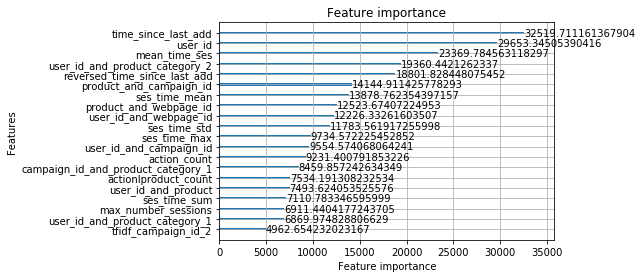

In [67]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain')

In [5]:
test_preds = pd.DataFrame({})
for f in os.listdir(ModelFolder+'/test'):
    temp = pd.read_csv(ModelFolder+'/test/'+f)
    temp.columns = [f]
    test_preds = pd.concat([test_preds, temp], axis=1)

In [18]:
test_preds.head()

,nfold0.csv,nfold1.csv,nfold2.csv,nfold3.csv,nfold4.csv,nfold5.csv,nfold6.csv,nfold7.csv,nfold8.csv,nfold9.csv
0,0.121438,0.121597,0.112649,0.102451,0.108558,0.101008,0.112192,0.102956,0.110762,0.111573
1,0.032633,0.036701,0.034490,0.036537,0.039645,0.036661,0.039656,0.037097,0.032133,0.030908
2,0.029407,0.032011,0.030999,0.033747,0.037945,0.035418,0.036770,0.035368,0.030126,0.028115
3,0.053751,0.052856,0.049813,0.052912,0.049048,0.047801,0.047266,0.051192,0.043987,0.058760
4,0.071553,0.070333,0.069886,0.068805,0.071984,0.071374,0.064305,0.077000,0.061249,0.067251


In [19]:
from scipy.stats.mstats import gmean

In [20]:
#ssub['is_click'] = test_preds.rank().mean(axis=1) #test_preds.mean(axis=1)
ssub['is_click'] = np.mean(test_preds, axis=1) #test_preds.mean(axis=1)
ssub.to_csv(ModelFolder+model_name+'_submit.csv',index=False)

In [21]:
ssub.head()

,session_id,is_click
0,411705,0.110518
1,208263,0.035646
2,239450,0.032991
3,547761,0.050739
4,574275,0.069374


In [72]:
# 

In [73]:
def permutation_feature_selection(model, X_val, y_val, pred_proba=False, rep=3, max_delta_score=0.0):
    from sklearn.metrics import roc_auc_score

    # to do: predict_proba from Booster

    """""
    Perform permutation feature importance calculation for trained LightGBM model. 
    Scorer - ROC AUC. 
    The lower score with permuted feature - the more important feature is. 
    
    Parameters
    ----------
    model : lightGBM.Booster
        Trained model to perform feature importance calculation 
        
    X_val : pandas.DataFrame
        Validation dataset
            
    y_val : pandas.Series 
        Targets for validation dataset
       
    rep : integer (default = 3)
        Number of permutations. More permutations lead to more robust results, but requires more calculation time.
        It is recommended to use values in the range [3; 10].
        
    min_delta_score : float (default = 0.0)
        Minimum delta ins score to keep feature 
        It is recommended to use values in the range [-0.0001; 0].
        
    Output
    ----------
    selected_features : list
        Important features 
        
    importance_df : pandas.DataFrame 
        Records of calculations 
    """""

    print('Permutation feature importance is calculating...')

    columns = []
    scores = []
    stds = []
    score_max = []
    score_min = []

    # calculate the score of model with no permuted features, this is our baseline
    y_hat_nopert = model.predict(X_val)
    score_init = roc_auc_score(y_val, y_hat_nopert)

    for cc in tqdm(X_val.columns):
        scores_cc = []
        for seed in range(rep):
            # shuffle single column of dataset
            data_temp = X_val.copy()
            data_temp[cc] = data_temp[cc].sample(n=X_val.shape[0], random_state=seed).reset_index(drop=True)

            # make prediction on 'shuffled' dataset and score it
            y_hat = model.predict(data_temp)
            score = roc_auc_score(y_val, y_hat)
            scores_cc.append(score)

        columns.append(cc)
        scores.append(np.mean(scores_cc) - score_init)
        stds.append(np.std(scores_cc))
        score_max.append(np.max(scores_cc) - score_init)
        score_min.append(np.min(scores_cc) - score_init)

    importance_df = pd.DataFrame({'delta_score_mean': scores,
                                  'delta_score_std': stds,
                                  'delta_score_max': score_max,
                                  'delta_score_min': score_min,
                                  'feature': columns
                                  })
    importance_df = importance_df.sort_values(by='delta_score_mean')
    selected_features = list(importance_df.loc[importance_df['delta_score_mean'] <= max_delta_score, 'feature'])

    print('Permutation feature importance calculation is done. Overall number of features: ', importance_df.shape[0],
          'Number of selected features:', len(selected_features))

    return selected_features, importance_df

In [74]:
selected_features, importance_df = permutation_feature_selection(model, X_val_temp, y_val_temp, rep=6)

Permutation feature importance is calculating...


100%|██████████████████████████████████████████████████████████████████████████████| 146/146 [1:03:43<00:00, 26.19s/it]


Permutation feature importance calculation is done. Overall number of features:  146 Number of selected features: 100


In [78]:
np.sum(importance_df[importance_df['delta_score_mean']>0]['delta_score_mean'])

0.006481017090644969

In [76]:
selected_features

['reversed_time_since_last_add',
 'time_since_last_add',
 'user_id',
 'action_count',
 'mean_time_ses',
 'ses_time_mean',
 'max_number_sessions',
 'actionlproduct_count',
 'ses_per_day_hist',
 'user_id_and_product_category_2',
 'ses_time_std',
 'max_hist_ses',
 'ses_time_max',
 'user_id_and_product',
 'ses_time_sum',
 'n_page_in_session',
 'tfidf_product_category_1_0',
 'user_id_and_product_category_1',
 'tfidf_campaign_id_7',
 'num_ads_ses',
 'campaign_id_and_product_category_1',
 'tfidf_campaign_id_2',
 'tfidf_product_2',
 'hist_num_active_days',
 'tfidf_product_category_2_29',
 'tfidf_product_3',
 'tfidf_product_category_1_4',
 'var_1_and_product_category_2',
 'actionlproduct_mean',
 'tfidf_webpage_id_2',
 'tfidf_product_category_2_1',
 'age_level_and_product_category_1',
 'tfidf_product_category_1_1',
 'tfidf_campaign_id_8',
 'tfidf_product_category_2_16',
 'product',
 'user_depth_and_campaign_id',
 'tfidf_webpage_id_4',
 'city_development_index_and_product',
 'gender_and_webpage_i

In [75]:
importance_df

,delta_score_max,delta_score_mean,delta_score_min,delta_score_std,feature
31,-0.009840,-0.011818,-0.013270,0.001403,reversed_time_since_last_add
19,-0.009745,-0.011521,-0.012947,0.001133,time_since_last_add
0,-0.004542,-0.005437,-0.006254,0.000620,user_id
16,-0.003039,-0.004921,-0.005940,0.000895,action_count
23,-0.002496,-0.003547,-0.004078,0.000571,mean_time_ses
26,-0.001865,-0.002515,-0.002952,0.000357,ses_time_mean
21,-0.002094,-0.002290,-0.002652,0.000211,max_number_sessions
18,-0.000757,-0.002123,-0.004103,0.001138,actionlproduct_count
14,-0.001199,-0.002051,-0.003011,0.000562,ses_per_day_hist
39,-0.000812,-0.001766,-0.002546,0.000604,user_id_and_product_category_2
